# Atmospheric processes: from cloud to global scales
# Exercise on radar, microphysics and mountain meteorology

## Introduction 

In this exercise, you will analyze numerical model simulations and observational data corresponding to snowfall events at Jungfraujoch (Switzerland) at 3463 m above sea level, in January 2014.

The purpose is to handle numerical model data and understand how changes in parameterizations can affect model outputs, and how this in turn can help understand the processes that are occurring during a given precipitation event.


### Before starting the exercise

The following instructions apply if you are running the exercise on the virtual desktop that was provided (VDI). Please refer to the corresponding PDF for instructions on how to install and run the VDI client.

In order to execute the code in this exercise, you will need to activate the `lte` environment (deployed on VDI).
- If you are running the notebook in Visual Studio Code, select this environment in the Kernel manager (icon at the top right of the code window).
- If you are using jupyterlab, make sure you properly activated the environment before launching jupyter-lab from the terminal:
    - Open a terminal, type `micromamba activate lte`
    - Then launch jupyterlab by typing `jupyter-lab`

To ensure that your work is properly saved when you logoff your VDI session, make sure that this Exercise notebook is in the `~/Desktop/MyFiles/` directory.

### General instructions
This exercise does not require to code in Python. You will simply have to execute the cells one after the other by pressing Shift + Enter. In some cells, you will have to adjust the values of certain variables, which will be specified clearly (in CAPITAL letters).

The questions will guide you through an interpretation of the radar variables, sounding profiles and model data in terms of cloud or precipitation microphysical properties and processes.
More difficult questions are indicated with a star (*).


In [1]:
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
from mch_parameters import params
import matplotlib.colors as colors
import matplotlib.dates as mdates
myFmt = mdates.DateFormatter('%d/%m')
plt.rcParams['font.size']=14
import wrf
import warnings
warnings.filterwarnings('ignore')


Below is a description of the numerical model that was used (adapted from Georgakaki et al., 2022, and from https://www2.mmm.ucar.edu/wrf/users/wrf_model.html)

*The simulations are computed with the Weather and Research Forecast (WRF) model, version 4.0, with augmented cloud microphysics to include the effects of additional secondary ice production (SIP) mechanisms (Sotiropoulou et al., 2021).\
The equation set in WRF is fully compressible, Eulerian and nonhydrostatic. It is conservative for scalar variables.\
The model uses terrain-following, hybrid sigma-pressure vertical coordinate with the top of the model being a constant pressure surface; a refined vertical grid spacing was used for these simulations following Vignon et al. 2021.\
The model has been run with three two-way nested domains (Fig. 1), with a respective horizontal resolution of 12, 3, and 1 km. The Lambert conformal projection is applied to all three domains. Arakawa-C grid staggering is used for the horizontal grid.\
The time integration scheme in the model uses the third-order Runge-Kutta scheme, and the spatial discretization employs 2nd to 6th order schemes.\
Regarding the physics options chosen to run the simulations, the Rapid Radiative Transfer Model for General Circulation Models (RRTMG) radiation scheme is applied to parameterize both the short-wave and long-wave radiative transfer.\
The vertical turbulent mixing is treated with the Mellor–Yamada–Janjić (MYJ; Janjić, 2001) 1.5 order scheme. The Kain–Fritsch cumulus parameterization has been activated only in the outermost domain, as the resolution of the two nested domains is sufficient to reasonably resolve cumulus-type clouds at grid scale.\
The fifth generation of the European Centre for Medium-Range Weather Forecasts (ECMWF) atmospheric reanalyses dataset (ERA5; Hersbach et al., 2020) is used to initialize the model and provide the lateral forcing at the edge of the 12 km resolution domain every 6h.*

> **Question 1** In the model description, identify keywords that were covered in class, and explain their meaning. 

- *"Fully compressible" and "nonhydrostatic": This means that air is compressible and elastic (contrary to anelastic approximation) and not hydrostatic (pressure gradient is not only gravity driven). This implies that the propagation of sound waves can be modeled, and corresponds to a high-resolution modeling setting. See session 4, slides 6-7.*
- *"Eulerian": the motion of the fluids is represented in a fixed time, space grid. This contrasts with Lagrangian modeling, which follows the trajectory of air parcels. See session 4, slide 27.*
- *"conservative for scalar variables": The conservation equations are verified for the scalar quantities, i.e., all except the motion equation (session 4, slide 5)*
- *"hybrid sigma-pressure vertical coordinate": this combines sigma-denominated layers at the bottom (following terrain, see def. of sigma in lecture session 4, slide 22) with isobaric (pressure-denominated) layers aloft.*
- *"three two-way nested domains": To achieve the best results in the location we are interested in, three domains are combined with different sizes and resolutions, to include as much as possible information sufficiently far from the center of the domain (largest domain, lowest resolution) while keeping the ability to resolve small-scale processes (smallest domain, highest resolution). See session 4, slide 18.*
- *"Lambert conformal projection": This is a conic projection which is angle-preserving. (Session 4, slides 12-13)*
- *"Arakawa-C grid staggering": Different quantities are computed on staggered grids, i.e. grids which are shifted from 0.5 increments in both directions in the horizontal dimension. This helps reduce numerical instabilities. (session 4, slide 29)*
- *"Third-order Runge Kutta scheme" and "2nd to 6th order schemes": This details the finite difference schemes which are used for temporal and spatial differentiation.*
- *"radiation scheme": this refers to the parameterization used to describe radiative fluxes which are a key driver of atmospheric dynamics (Session 5, slides 11-19)*
- *"vertical turbulent mixing is treated with Mellor-Yamada-Janjic": This refers to the turbulent closure, i.e. choice of how to approximate unknowns in modeling of turbulence (session 5, slides 7-9).*
- *"Kain-Fritsch cumulus parameterization": This is a parameterization of convective processes (session 5, slide 24).*

> **Question 2** Discuss the choice of the projection.

*A Lambert conformal projection is adequate for areas with limited distortion, which is the case for midlatitude regions like Central Europe.*

> **Question 3** How do you understand the sentence "The Kain–Fritsch cumulus parameterization (...) at grid scale"? 

*This illustrates the concept of parameterization: for the domains with high resolution, the scale is small enough to implement a numerical model of physical equations describing a mechanism (here, convection). For the low-resolution domain, the scale is too big: for instance, convective clouds may form which have a size smaller than the grid cell; in this domain, it is necessary to define a parameterization for convective processes i.e., described in a simplified way in such a way that the effect of convection at the model scale is represented.*

We first assess the ability of the model to reproduce observed standard atmospheric variables: Temperature, relative humidity, wind speed and wind direction.
This is a first safety check to ensure that the simulations are able to capture accurately the atmospheric conditions on the days of the events. For this, we look at the output of the control simulations (CNTRL), i.e., with the default parameterizations.

For this, we compare modeled fields to measurements from an automatic weather station of MeteoSwiss located at Jungfraujoch.


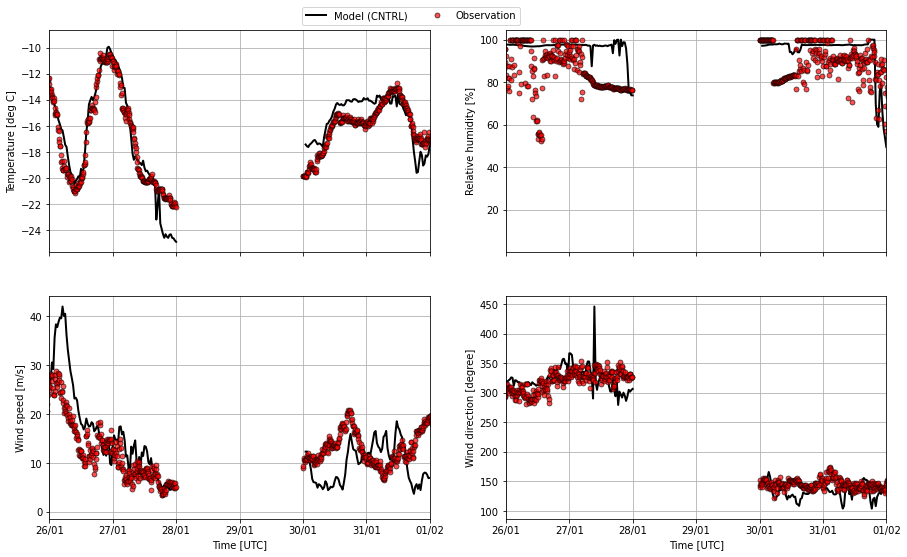

In [2]:
## Loading and preparing data

ctrl_nw = Dataset('Data/WRF/CNTRL_NW.nc')
ctrl_se = Dataset('Data/WRF/CNTRL_SE.nc')

t0_nw = datetime.datetime.timestamp(datetime.datetime(year=2014, month=1, day=25, hour=0, tzinfo = datetime.timezone.utc))
t0_se = datetime.datetime.timestamp(datetime.datetime(year=2014, month=1, day=29, hour=0, tzinfo = datetime.timezone.utc))
dt_nw = [datetime.datetime.fromtimestamp(tt*60+t0_nw, tz=datetime.timezone.utc) for tt in ctrl_nw.variables['XTIME'][:]]
dt_se = [datetime.datetime.fromtimestamp(tt*60+t0_se, tz=datetime.timezone.utc) for tt in ctrl_se.variables['XTIME'][:]]

i_start = 50

mch_obs = pd.read_fwf('Data/observations/MCH_JFJ_data_10min.txt')
dt_mch = pd.to_datetime(mch_obs['time'],format='%Y%m%d%H%M')
for var in mch_obs.columns[2:]:
    params[var]['data'] = mch_obs[var].replace('-','nan').to_numpy(dtype='f')
mch_vars = ['tre200s0', 'ure200s0','fkl010z0', 'dkl010z0']

            
ctrl_temp_nw = wrf.getvar(ctrl_nw,'T2',timeidx=wrf.ALL_TIMES)-273.15
ctrl_temp_se = wrf.getvar(ctrl_se,'T2',timeidx=wrf.ALL_TIMES)-273.15
ctrl_rh_nw = wrf.getvar(ctrl_nw,'rh2',timeidx=wrf.ALL_TIMES)
ctrl_rh_se = wrf.getvar(ctrl_se,'rh2',timeidx=wrf.ALL_TIMES)

ctrl_wspd_nw = np.sqrt(ctrl_nw.variables['U10'][:,0,0]**2+ctrl_nw.variables['V10'][:,0,0]**2)
ctrl_wspd_se = np.sqrt(ctrl_se.variables['U10'][:,0,0]**2+ctrl_se.variables['V10'][:,0,0]**2)
ctrl_wdir_nw = np.arctan(ctrl_nw.variables['V10'][:,0,0]/ctrl_nw.variables['U10'][:,0,0])*180/np.pi+360
ctrl_wdir_se = np.arctan(ctrl_se.variables['V10'][:,0,0]/ctrl_se.variables['U10'][:,0,0])*180/np.pi+180

##############################################

## Plotting 
plt.rcParams['font.size']=14
fig, axs = plt.subplots(2,2,figsize=(15,9), sharex=True)

axs[0,0].plot(dt_nw, ctrl_temp_nw,'k',lw=2, label = 'Model (CNTRL)')
axs[0,0].plot(dt_se[i_start:], ctrl_temp_se[i_start:],'k',lw=2)
axs[0,1].plot(dt_nw,ctrl_rh_nw,'k',lw=2)
axs[0,1].plot(dt_se[i_start:],ctrl_rh_se[i_start:],'k',lw=2)
axs[1,0].plot(dt_nw,ctrl_wspd_nw,'k',lw=2)
axs[1,0].plot(dt_se[i_start:],ctrl_wspd_se[i_start:],'k',lw=2)
axs[1,1].plot(dt_nw,ctrl_wdir_nw,'k',lw=2)
axs[1,1].plot(dt_se[i_start:],ctrl_wdir_se[i_start:],'k',lw=2)

for i_ax, ax in enumerate(axs.flatten()):
    ax.plot(dt_mch,params[mch_vars[i_ax]]['data'],linestyle='', marker='o',markersize=5, color='red',markeredgecolor='k',mew=0.75,alpha=.7, label='Observation')
    ax.set_ylabel(params[mch_vars[i_ax]]['name']+' ['+params[mch_vars[i_ax]]['units']+']')
    ax.grid(zorder=100)
    ax.set_xlim(datetime.datetime(2014,1,26), datetime.datetime(2014,2,1))
    ax.xaxis.set_major_formatter(myFmt)
axs[1,0].set_xlabel('Time [UTC]')
axs[1,1].set_xlabel('Time [UTC]')
axs[0,0].legend(ncol=2, bbox_to_anchor = (0.65,1),loc='lower left')

> **Question 4** What do you think of the agreement between the model outputs and the observations, for each of the variables plotted above?

*Overall, the agreement between the model outputs and the observations is relatively good.*
- *Temperature: The agreement is very good for the first part of the time series; in the second part, the model overestimates slightly the temperature.*
- *Relative humidity: Some periods of the time series are not very well captured. For instance, on 27/01 the model seems to identify a cloud (RH close to 100%) while the observed RH is lower.*
- *Wind speed: The temporal trend is well captured in the first part of the time series in spite of a light overestimation. In the second part of the time series, the agreement is lower.*
- *Wind direction: The agreement is good throughout the time series.*

We then investigate the model results in terms of ice crystal number concentration (ICNC), ice water content (IWC) and liquid water content (LWC).

> **Question 5** Why are these variables interesting? Think of their relevance for both climate and weather research.

*The ice crystal number concentration is important for the radiative properties of the ice clouds. The phase partitioning described with IWC and LWC is also significant for the radiative properties as liquid and ice species have different scattering properties.*

*ICNC, IWC and LWC are relevant for weather forecasting to simulate cloud and precipitation processes. Precipitation is directly related to IWC and LWC.* 

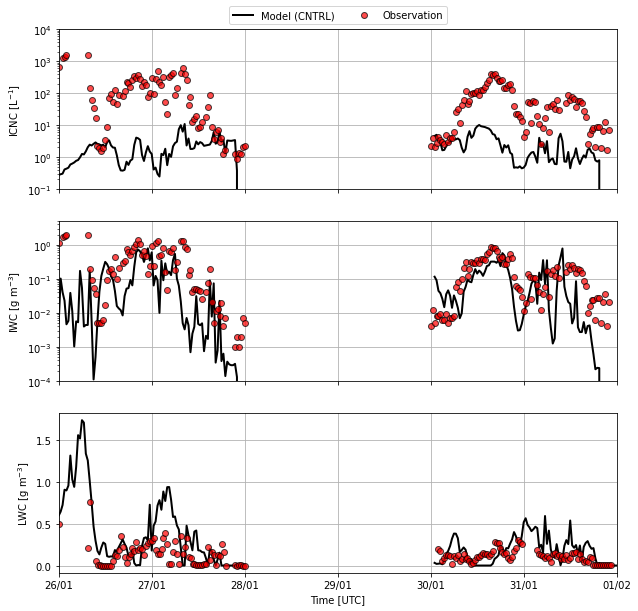

In [3]:
## Load and prepare data

icnc_obs_nw = pd.read_csv('Data/observations/ICNC_obs_NW.csv',sep=';')
iwc_obs_nw = pd.read_csv('Data/observations/IWC_obs_NW.csv',sep=';')
lwc_obs_nw = pd.read_csv('Data/observations/LWC_obs_NW.csv',sep=';')
icnc_obs_se = pd.read_csv('Data/observations/ICNC_obs_SE.csv',sep=';')
iwc_obs_se = pd.read_csv('Data/observations/IWC_obs_SE.csv',sep=';')
lwc_obs_se = pd.read_csv('Data/observations/LWC_obs_SE.csv',sep=';')

vars_icnc = ['QNGRAUPEL', 'QNICE', 'QNSNOW']
vars_iwc = ['QGRAUP', 'QICE', 'QSNOW']
vars_lwc = ['QCLOUD', 'QRAIN']

rho_air_nw = ctrl_nw.variables['PSFC'][:,0,0] / ctrl_nw.variables['T2'][:,0,0] / 287
rho_air_se = ctrl_se.variables['PSFC'][:,0,0] / ctrl_se.variables['T2'][:,0,0] / 287

ICNC_NW = sum([ctrl_nw.variables[v][:,0,0,0] for v in vars_icnc])*rho_air_nw*1e-3
ICNC_SE = sum([ctrl_se.variables[v][:,0,0,0] for v in vars_icnc])*rho_air_se*1e-3
IWC_NW = sum([ctrl_nw.variables[v][:,0,0,0] for v in vars_iwc])*rho_air_nw*1e3
IWC_SE = sum([ctrl_se.variables[v][:,0,0,0] for v in vars_iwc])*rho_air_se*1e3
LWC_NW = sum([ctrl_nw.variables[v][:,0,0,0] for v in vars_lwc])*rho_air_nw*1e3
LWC_SE = sum([ctrl_se.variables[v][:,0,0,0] for v in vars_lwc])*rho_air_se*1e3

#######################################################
## Plotting

fig, axs = plt.subplots(3,figsize=(10,10),sharex=True)
axs[0].plot(dt_nw, ICNC_NW,'k',lw=2,label='Model (CNTRL)')
axs[0].plot(dt_se[i_start:], ICNC_SE[i_start:],'k', lw=2)
axs[0].plot(pd.to_datetime(icnc_obs_nw['Datetime(dd/mm/yyyy h:mm)']), icnc_obs_nw['ICNC(L-1)'], linestyle='', marker='o', color='red', markeredgecolor='k',alpha=.7, label = 'Observation')
axs[0].plot(pd.to_datetime(icnc_obs_se['Datetime(dd/mm/yyyy h:mm)']), icnc_obs_se['ICNC(L-1)'], linestyle='', marker='o', color='red', markeredgecolor='k',alpha=.7)
axs[0].set_yscale('log')
axs[0].set_ylim(0.1, 1e4)
axs[0].set_ylabel('ICNC [L$^{-1}$]')
axs[0].legend(bbox_to_anchor=(0.5,1),loc='lower center',ncol=2)

axs[1].plot(dt_nw,IWC_NW,'k',lw=2)
axs[1].plot(dt_se[i_start:],IWC_SE[i_start:],'k',lw=2)
axs[1].plot(pd.to_datetime(iwc_obs_nw['Datetime(dd/mm/yyyy h:mm)']), iwc_obs_nw['IWC(gm-3)'], linestyle='', marker='o', color='red', markeredgecolor='k',alpha=.7)
axs[1].plot(pd.to_datetime(iwc_obs_se['Datetime(dd/mm/yyyy h:mm)']), iwc_obs_se['IWC(gm-3)'], linestyle='', marker='o', color='red', markeredgecolor='k',alpha=.7)
axs[1].set_yscale('log')
axs[1].set_ylim(1e-4,5)
axs[1].set_ylabel('IWC [g m$^{-3}$]')

axs[2].plot(dt_nw,LWC_NW,'k',lw=2)
axs[2].plot(dt_se[i_start:], LWC_SE[i_start:],'k',lw=2)
axs[2].plot(pd.to_datetime(lwc_obs_nw['Datetime(dd/mm/yyyy h:mm)']), lwc_obs_nw['LWC(gm-3)'], linestyle='', marker='o', color='red', markeredgecolor='k',alpha=.7)
axs[2].plot(pd.to_datetime(lwc_obs_se['Datetime(dd/mm/yyyy h:mm)']), lwc_obs_se['LWC(gm-3)'], linestyle='', marker='o', color='red', markeredgecolor='k',alpha=.7)
axs[2].set_ylabel('LWC [g m$^{-3}$]')
axs[2].set_xlabel('Time [UTC]')

for ax in axs.flatten():
    ax.set_xlim(datetime.datetime(2014,1,26), datetime.datetime(2014,2,1))
    ax.xaxis.set_major_formatter(myFmt)
    ax.grid()



>**Question 6** What do you think of the agreement between the model outputs and the observations, for each of the variables plotted above.

- *ICNC: the model significantly underestimates the observations by several orders of magnitude*
- *IWC: The agreement is reasonable, although the model underestimates a little the observations*
- *LWC: During certain periods, the agreement is OK, but in other periods the model overestimates significantly the LWC (e.g., beginning of 27/01)*

>**Question 6bis** Compare the model/obs agreement for ICNC and IWC. What does it reflect about the particle size distribution (PSD)?

*As seen in the previous question, the model/obs agreement is much better for IWC than ICNC. This means that the total mass of ice is reasonably well modeled but not the number of crystals, i.e. the mass of ice in the model outputs is contained in fewer particles. This suggests that the model simulates a PSD with more large particles and much fewer small particles than in reality.*

In the next questions, we will explore the sensitivity of the model outputs to changes in the microphysical parameterizations. The sensitivity simulations explore the possible impact of secondary ice production (SIP) and blowing snow processes.

> **Question 7** Recall what secondary ice production refers to.

*Secondary ice production is the formation of ice crystals through other processes than those of primary ice production, which includes the formation of ice crystals through homogeneous nucleation at very cold temperatues (<-40°C) or heterogeneous nucleation onto ice nucleating particles (INP). Secondary ice production typically takes place as a result of interactions between ice / snow particles that generate new fragments*

Different mechanisms for secondary ice production exist (Korolev et al., 2020). For instance:
- ***Droplet shattering*** occurs when a large supercooled liquid water drop freezes (upon contact with an ice nucleating particle or with an ice crystal) and shatters into several ice fragments. This is due to the differential pressure resultng from the formation of an outer shell on the drop.
- ***Collisional breakup*** occurs when collisions between ice crystals produce ice fragments. The collisions are typically facilitated in regions with atmospheric turbulence, or when ice particles have different settling velocities. The presence of rimed particles is an important ingredient as these particles, with their higher mass and fall speed, are more likely to cause efficient breakup during high-kinetic-energy collisions with other ice particles.

In addition, another process that can take place in mountainous regions is ***blowing snow***, i.e., snow particles being lifted from the surface by wind. 


The simulations that were conducted are the following:
- `CNTRL`: Control simulation, plotted in the previous cell.
- `BIPS_10`: Includes blowing snow processes, modeled with a constant source of ice crystals at the lowest model level ($10 L^{-1}$). The ice particles injected in the atmosphere from the surface are then redistributed through advection, sublimation and sedimentation.
- `BIPS_100`: Same but with a higher injection of blowing snow particles ($100 L^{-1}$).
- `DS_PHILL`: Includes SIP through droplet shattering, simulated with the parameterization of Phillips et al., 2018.
- `DS_SULL`: Includes SIP through droplet shattering, simulated with a different parameterization (Sullivan et al., 2018)
- `BR_PHILL`: Includes SIP through collisional breakup, simulated with the parameterization of Phillips et al., 2017.
- `BR_TAKAH`: Includes SIP through collisional breakup, simulated with the parameterization of Takahashi et al., 1995.
- `BR_TAKAHrim`: Includes SIP through collisional breakup, simulated with the parameterization of Takahashi et al., 1995, activated only after collisions between rimed particles.
- `BIPS100_PHILL`: Includes SIP through collisional breakup (Phillips et al., 2017) and blowing snow ($100 L^{-1}$)


In the cell below, define the list of simulations that you want to display (you can plot them all at once but this may be more difficult to read) inside the variable `SIM_LIST`.\
-> In the first figure, we display the time series of model outputs (for the selected simulation settings) and observations.\
-> In the second figure, we plot the distributions of each variable for observations and for the model outputs. NB to plot the simulated LWC distributions, we remove the beginning of the timeseries where observations are missing, as this could bias the comparison.

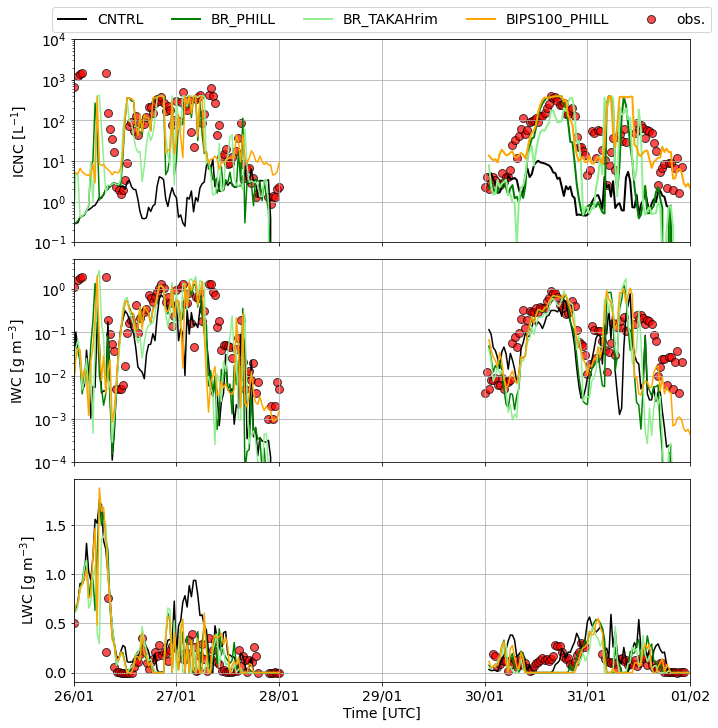

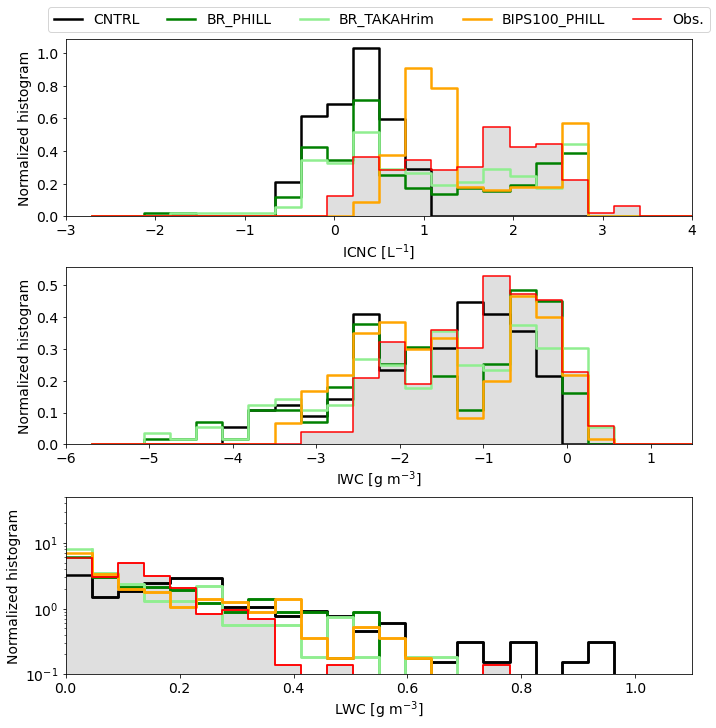

In [7]:
SIM_LIST = ['CNTRL', 
            # 'BIPS_10', 
            # 'BIPS_100', 
            # 'DS_PHILL', 
            # 'DS_SULL', 
            'BR_PHILL', 
            # 'BR_TAKAH', 
            'BR_TAKAHrim', 
            'BIPS100_PHILL'
            ]

####################################################

color_dict = {'CNTRL':'k', 'BIPS_10':'deepskyblue', 'BIPS_100': 'royalblue', 'DS_PHILL':'hotpink', 'DS_SULL':'violet', 'BR_PHILL':'green', 'BR_TAKAH':'turquoise', 'BR_TAKAHrim': 'lightgreen', 'BIPS100_PHILL':'orange'}
if len(SIM_LIST)<=4:
    ncol = len(SIM_LIST)+1
else:
    ncol = int((len(SIM_LIST)+2)/2)

i_start_nw = 48
i_start_se = 50
i_start_nw_lwc = 68 # because we have a lot of NaN in the obs

plt.rcParams['font.size']=14

fig, axs = plt.subplots(3,figsize=(10,10),sharex=True,constrained_layout = True)
for sim in SIM_LIST:
    nc_tp_nw = Dataset(f'Data/WRF/{sim}_NW.nc')
    nc_tp_se = Dataset(f'Data/WRF/{sim}_SE.nc')

    rho_air_nw = nc_tp_nw.variables['PSFC'][:,0,0] / ctrl_nw.variables['T2'][:,0,0] / 287
    rho_air_se = nc_tp_se.variables['PSFC'][:,0,0] / ctrl_se.variables['T2'][:,0,0] / 287

    ICNC_NW = sum([nc_tp_nw.variables[v][:,0,0,0] for v in vars_icnc])*rho_air_nw*1e-3
    ICNC_SE = sum([nc_tp_se.variables[v][:,0,0,0] for v in vars_icnc])*rho_air_se*1e-3
    IWC_NW = sum([nc_tp_nw.variables[v][:,0,0,0] for v in vars_iwc])*rho_air_nw*1e3
    IWC_SE = sum([nc_tp_se.variables[v][:,0,0,0] for v in vars_iwc])*rho_air_se*1e3
    LWC_NW = sum([nc_tp_nw.variables[v][:,0,0,0] for v in vars_lwc])*rho_air_nw*1e3
    LWC_SE = sum([nc_tp_se.variables[v][:,0,0,0] for v in vars_lwc])*rho_air_se*1e3

    axs[0].plot(dt_nw, ICNC_NW,color_dict[sim])
    axs[0].plot(dt_se[i_start_se:], ICNC_SE[i_start_se:],color_dict[sim], lw=2, label=sim)    

    axs[1].plot(dt_nw,IWC_NW,color_dict[sim])
    axs[1].plot(dt_se[i_start_se:],IWC_SE[i_start_se:],color_dict[sim])
    
    axs[2].plot(dt_nw[48:],LWC_NW[48:],color_dict[sim])
    axs[2].plot(dt_se[i_start_se:], LWC_SE[i_start_se:],color_dict[sim])
    

axs[0].plot(pd.to_datetime(icnc_obs_nw['Datetime(dd/mm/yyyy h:mm)']), icnc_obs_nw['ICNC(L-1)'], linestyle='', marker='o', markersize=8, color='red', markeredgecolor='k',alpha=.7,zorder=-1,label='obs.')
axs[0].plot(pd.to_datetime(icnc_obs_se['Datetime(dd/mm/yyyy h:mm)']), icnc_obs_se['ICNC(L-1)'], linestyle='', marker='o', markersize=8, color='red', markeredgecolor='k',alpha=.7,zorder=-1)
axs[0].set_yscale('log')
axs[0].set_ylim(0.1, 1e4)
axs[0].set_ylabel('ICNC [L$^{-1}$]')

axs[1].plot(pd.to_datetime(iwc_obs_nw['Datetime(dd/mm/yyyy h:mm)']), iwc_obs_nw['IWC(gm-3)'], linestyle='', marker='o', markersize=8, color='red', markeredgecolor='k',alpha=.7,zorder=-1)
axs[1].plot(pd.to_datetime(iwc_obs_se['Datetime(dd/mm/yyyy h:mm)']), iwc_obs_se['IWC(gm-3)'], linestyle='', marker='o', markersize=8, color='red', markeredgecolor='k',alpha=.7,zorder=-1)
axs[1].set_yscale('log')
axs[1].set_ylim(1e-4,5)
axs[1].set_ylabel('IWC [g m$^{-3}$]')

axs[2].plot(pd.to_datetime(lwc_obs_nw['Datetime(dd/mm/yyyy h:mm)']), lwc_obs_nw['LWC(gm-3)'], linestyle='', marker='o', markersize=8, color='red', markeredgecolor='k',alpha=.7,zorder=-1)
axs[2].plot(pd.to_datetime(lwc_obs_se['Datetime(dd/mm/yyyy h:mm)']), lwc_obs_se['LWC(gm-3)'], linestyle='', marker='o', markersize=8, color='red', markeredgecolor='k',alpha=.7,zorder=-1)
axs[2].set_ylabel('LWC [g m$^{-3}$]')
axs[2].set_xlabel('Time [UTC]')

for ax in axs.flatten():
    ax.set_xlim(datetime.datetime(2014,1,26), datetime.datetime(2014,2,1))
    ax.xaxis.set_major_formatter(myFmt)
    ax.grid()
axs[0].legend(ncol=ncol,bbox_to_anchor=(0.5,1),loc='lower center')


#####################

fig, axs = plt.subplots(3,figsize=(10,10),constrained_layout = True)
nbins = 25
bins_icnc = np.linspace(-3.,4,nbins)
bins_iwc = np.linspace(-6,1.5,nbins)
bins_lwc = np.linspace(0.,1.1,nbins)

for sim in SIM_LIST:
    nc_tp_nw = Dataset(f'Data/WRF/{sim}_NW.nc')
    nc_tp_se = Dataset(f'Data/WRF/{sim}_SE.nc')

    rho_air_nw = nc_tp_nw.variables['PSFC'][i_start_nw:,0,0] / ctrl_nw.variables['T2'][i_start_nw:,0,0] / 287
    rho_air_se = nc_tp_se.variables['PSFC'][i_start_se:,0,0] / ctrl_se.variables['T2'][i_start_se:,0,0] / 287

    ICNC_NW = sum([nc_tp_nw.variables[v][i_start_nw:,0,0,0] for v in vars_icnc])*rho_air_nw*1e-3
    ICNC_SE = sum([nc_tp_se.variables[v][i_start_se:,0,0,0] for v in vars_icnc])*rho_air_se*1e-3
    IWC_NW = sum([nc_tp_nw.variables[v][i_start_nw:,0,0,0] for v in vars_iwc])*rho_air_nw*1e3
    IWC_SE = sum([nc_tp_se.variables[v][i_start_se:,0,0,0] for v in vars_iwc])*rho_air_se*1e3
    LWC_NW = sum([nc_tp_nw.variables[v][i_start_nw_lwc:,0,0,0] for v in vars_lwc])*rho_air_nw[i_start_nw_lwc-i_start_nw:]*1e3
    LWC_SE = sum([nc_tp_se.variables[v][i_start_se:,0,0,0] for v in vars_lwc])*rho_air_se*1e3

    nnw,bnw = np.histogram(np.log10(np.concatenate((ICNC_NW[ICNC_NW>0], ICNC_SE[ICNC_SE>0]))), bins = bins_icnc,density = True)
    axs[0].step( bnw[1:], nnw, linewidth=2.5, color = color_dict[sim], label=sim)
    nnw,bnw = np.histogram(np.log10(np.concatenate((IWC_NW[IWC_NW>0], IWC_SE[IWC_SE>0]))), bins = bins_iwc,density = True)
    axs[1].step( bnw[1:], nnw, linewidth=2.5, color = color_dict[sim], label=sim)
    nnw,bnw = np.histogram((np.concatenate((LWC_NW[LWC_NW>0], LWC_SE[LWC_SE>0]))), bins = bins_lwc,density = True)
    axs[2].step( bnw[1:], nnw, linewidth=2.5, color = color_dict[sim], label=sim)
    axs[2].step( bnw[:-1], nnw, linewidth=2.5, color = color_dict[sim], label=sim, where='post')
    
nobs,bobs = np.histogram(np.log10(np.concatenate((icnc_obs_nw['ICNC(L-1)'], icnc_obs_se['ICNC(L-1)']))), bins = bins_icnc, density = True)
axs[0].step(bobs[1:], nobs, color='r', label = 'Obs.')
axs[0].hist(np.log10(np.concatenate((icnc_obs_nw['ICNC(L-1)'], icnc_obs_se['ICNC(L-1)']))), bins = bins_icnc, density = True, color='gray',alpha=.25,zorder=-1)
axs[0].set_xlim(bobs[0],bobs[-1])

nobs,bobs = np.histogram(np.log10(np.concatenate((iwc_obs_nw['IWC(gm-3)'], iwc_obs_se['IWC(gm-3)']))), bins = bins_iwc, density = True)
axs[1].step(bobs[1:], nobs, color='r')
axs[1].hist(np.log10(np.concatenate((iwc_obs_nw['IWC(gm-3)'], iwc_obs_se['IWC(gm-3)']))), bins = bins_iwc, density = True, color='gray',alpha=.25,zorder=-1)
axs[1].set_xlim(bobs[0],bobs[-1])

nobs,bobs = np.histogram((np.concatenate((lwc_obs_nw['LWC(gm-3)'], lwc_obs_se['LWC(gm-3)']))), bins = bins_lwc, density = True)
axs[2].step(bobs[1:], nobs, color='r')
axs[2].step(bobs[:-1], nobs, color='r',where='post')
axs[2].hist((np.concatenate((lwc_obs_nw['LWC(gm-3)'], lwc_obs_se['LWC(gm-3)']))), bins = bins_lwc, density = True, color='gray',alpha=.25,zorder=-1)
axs[2].set_xlim(bobs[0],bobs[-1])

axs[0].legend(ncol=ncol,bbox_to_anchor=(0.5,1),loc='lower center')

axs[0].set_xlabel('ICNC [L$^{-1}$]')
axs[1].set_xlabel('IWC [g m$^{-3}$]')
axs[2].set_xlabel('LWC [g m$^{-3}$]')
axs[2].set_yscale('log')
axs[2].set_ylim(.1,50)

for ax in axs.flatten():
    ax.set_ylabel('Normalized histogram')

> **Question 8** Based on both figures (timeseries and histograms), discuss the results of each sensitivity simulation, for the three variables (ICNC, IWC, LWC).

- *BIPS10: almost no improvement compared to CNTRL, for all variables.*
- *BIPS100: slight improvement for ICNC with an increase of the baseline level; however the temporal variability is still completely misrepresented. Minor improvement for IWC, no improvement for LWC.*
- *DS_PHILL: no improvement compared to CNTRL, for all variables.*
- *DS_SULL: no improvement compared to CNTRL, for all variables.*
- *BR_PHILL: substantial improvement for ICNC, still some time periods where underestimates obs (e.g. second half of 31/01); also improvement for IWC; for LWC: not perfect but manages to remove the erroneous peak around 06:00 on 27/01.*
- *BR_TAKAH: improvement for ICNC with respect to CNTRL, but sometimes overestimates the observations (particularly visible in the distribution plots)*
- *BR_TAKAHrim: substantial improvement for ICNC, similar as BR_PHILL but slightly worse (underestimation of ICNC on 30/01); similar improvement for IWC and LWC*
- *BIPS100_PHILL: substantial improvement for ICNC, better than BR_TAKAHrim and BR_PHILL in the time frames with lower ICNC; this is visible in the distribution plots (the extent of the ICNC distribution with this parameterization is almost the same as the for the observations). Also improvement for IWC on the low-IWC end, and improvement in LWC with still slight overestimation (but better than the others)*


>**Question 8bis** What set(s) of simulations provides the best match with the observations? What does it reveal about the microphysical process(es) that are likely taking place? 

*It results from the previous question that the best agreement comes from the BIPS100_PHILL simulations. This suggests that secondary ice production is taking place through collisional breakup, and that blowing snow from the surface is also occurring.*

To get a better understanding of how the "best" simulation differs from the control one, we will now look at model fields aloft, i.e., at the full vertical profiles of certain relevant variables (instead of point values at the surface).

In the next cell, we show the time-height plots of IWC, LWC and ICNC for the control simulation.


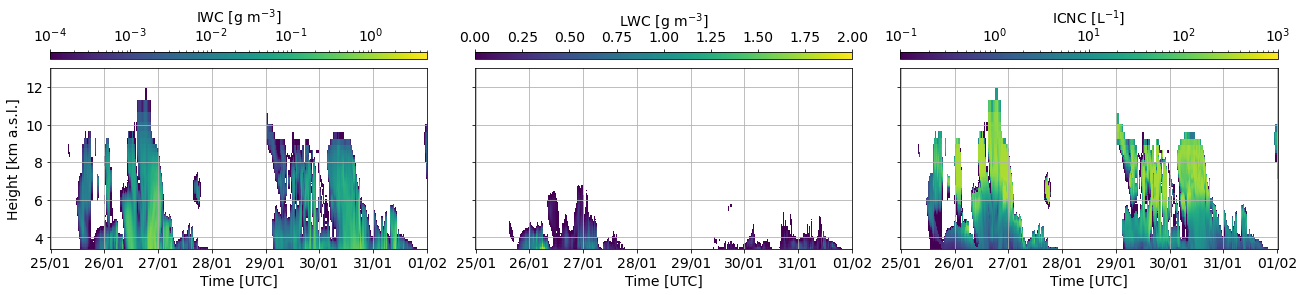

In [8]:
tk_nw = np.array([wrf.getvar(ctrl_nw,'tk',timeidx=i) for i in range(len(ctrl_nw.variables['XTIME']))])
P_nw = (ctrl_nw.variables['P'][:,:,0,0]+ctrl_nw.variables['PB'][:,:,0,0])
rho_profile_nw = P_nw / tk_nw / 287

tk_se = np.array([wrf.getvar(ctrl_se,'tk',timeidx=i) for i in range(len(ctrl_se.variables['XTIME']))])
P_se = (ctrl_se.variables['P'][:,:,0,0]+ctrl_se.variables['PB'][:,:,0,0])
rho_profile_se = P_se / tk_se / 287

ICNC_NW_profile = sum([ctrl_nw.variables[v][:,:,0,0] for v in vars_icnc])*rho_profile_nw*1e-3
ICNC_SE_profile = sum([ctrl_se.variables[v][:,:,0,0] for v in vars_icnc])*rho_profile_se*1e-3

IWC_NW_profile =  sum([ctrl_nw.variables[v][:,:,0,0] for v in vars_iwc])*rho_profile_nw*1e3
IWC_SE_profile = sum([ctrl_se.variables[v][:,:,0,0] for v in vars_iwc])*rho_profile_se*1e3

LWC_NW_profile =  sum([ctrl_nw.variables[v][:,:,0,0] for v in vars_lwc])*rho_profile_nw*1e3
LWC_SE_profile = sum([ctrl_se.variables[v][:,:,0,0] for v in vars_lwc])*rho_profile_se*1e3
LWC_NW_profile[LWC_NW_profile==0] = np.nan
LWC_SE_profile[LWC_SE_profile==0] = np.nan

PHB = ctrl_nw.variables["PHB"][:,:,0,0]
PH = ctrl_nw.variables["PH"][:,:,0,0]
ZZASL = (PH+PHB)/9.81
dz = (ZZASL[:,1:]-ZZASL[:,:-1])/2
ZZASL_nw = (ZZASL[:,:-1]+dz).mean(axis=0)

PHB = ctrl_se.variables["PHB"][:,:,0,0]
PH = ctrl_se.variables["PH"][:,:,0,0]
ZZASL = (PH+PHB)/9.81
dz = (ZZASL[:,1:]-ZZASL[:,:-1])/2
ZZASL_se = (ZZASL[:,:-1]+dz).mean(axis=0)


fig, axs = plt.subplots(1,3,figsize=(18,4),sharey=True, constrained_layout = True)
axs[0].pcolormesh(dt_se,ZZASL_se/1e3,IWC_SE_profile.T,norm=colors.LogNorm(vmin=1e-4,vmax=5))
im0 = axs[0].pcolormesh(dt_nw,ZZASL_nw/1e3,IWC_NW_profile.T,norm=colors.LogNorm(vmin=1e-4,vmax=5))
axs[1].pcolormesh(dt_se,ZZASL_se/1e3,LWC_SE_profile.T,vmin=0,vmax=2)
im1 = axs[1].pcolormesh(dt_nw,ZZASL_nw/1e3,LWC_NW_profile.T,vmin = 0,vmax=2)
axs[2].pcolormesh(dt_se,ZZASL_se/1e3,ICNC_SE_profile.T,norm=colors.LogNorm(vmin=1e-1,vmax=1e3))
im2 = axs[2].pcolormesh(dt_nw,ZZASL_nw/1e3,ICNC_NW_profile.T,norm=colors.LogNorm(vmin=1e-1,vmax=1e3))
plt.colorbar(im0,ax=axs[0],orientation='horizontal', location = 'top',aspect = 50, label = 'IWC [g m$^{-3}$]')
plt.colorbar(im1,ax=axs[1],orientation='horizontal',location='top',aspect = 50, label='LWC [g m$^{-3}$]')
plt.colorbar(im2,ax=axs[2],orientation='horizontal', location = 'top',aspect=50, label = 'ICNC [L$^{-1}$]')
axs[0].set_ylim(3.392,13)
axs[0].set_ylabel('Height [km a.s.l.]')
for ax in axs.flatten():
    ax.xaxis.set_major_formatter(myFmt)
    ax.grid()
    ax.set_xlabel('Time [UTC]')

> **Question 9** Focusing on the profiles of IWC and LWC, describe the cloud structure: is the cloud fully glaciated, is it a mixed phase cloud, or is the composition altitude-dependent (i.e., cloud layers with different properties are present)?

*There are at least two cloud layers with different properties; at the top of the cloud system, the cloud is fully glaciated (no LWC, only IWC); in the lower layers, a mixed phase cloud is present (both LWC and IWC).* 

> **Question 9bis (*)** What is the name of such a configuration? Recall what happens in such cases. Here, what microphysical process do you think this favors?

*This is a seeder-feeder configuration: ice crystals are precipitating from aloft (seeder) into a liquid/mixed-phase lower-lying cloud (feeder).*

> **Question 10** Focus on the profiles of ICNC. What is the general trend in ICNC from the top to bottom of the cloud? What process is likely taking place?
*The general trend is that ICNC increases slightly around the top of the cloud (due to the production of new ice crystals through nucleation), then decreases around ~6 km asl. IWC does not decrease at the same altitude, meaning that the total mass of ice remains approximately the same. This suggest that ice crystals may be aggregating together (leading to a decrease of ICNC, while IWC remains stable).*

We now plot the same fields but from the simulation that you identified as the one that fitted the observations best (set the `SIM` variable in the cell below).

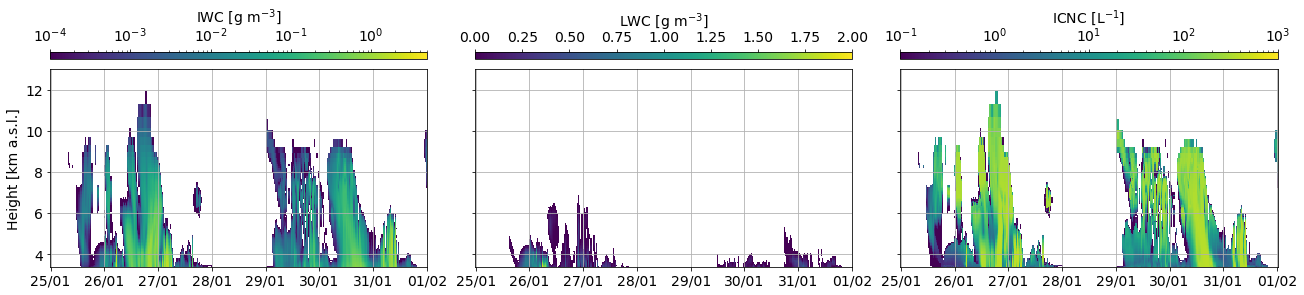

In [10]:
SIM = 'BIPS100_PHILL'

###############################
if SIM == '':
    raise SystemExit("Please set the SIM variable.")

sim_nw = Dataset(f'Data/WRF/{SIM}_NW.nc')
sim_se = Dataset(f'Data/WRF/{SIM}_SE.nc')
    
tk_nw = np.array([wrf.getvar(sim_nw,'tk',timeidx=i) for i in range(len(ctrl_nw.variables['XTIME']))])
P_nw = (sim_nw.variables['P'][:,:,0,0]+sim_nw.variables['PB'][:,:,0,0])
rho_profile_nw_sim = P_nw / tk_nw / 287

tk_se = np.array([wrf.getvar(sim_se,'tk',timeidx=i) for i in range(len(ctrl_se.variables['XTIME']))])
P_se = (sim_se.variables['P'][:,:,0,0]+ctrl_se.variables['PB'][:,:,0,0])
rho_profile_se_sim = P_se / tk_se / 287

ICNC_NW_profile_sim = sum([sim_nw.variables[v][:,:,0,0] for v in vars_icnc])*rho_profile_nw_sim*1e-3
ICNC_SE_profile_sim = sum([sim_se.variables[v][:,:,0,0] for v in vars_icnc])*rho_profile_se_sim*1e-3

IWC_NW_profile_sim =  sum([sim_nw.variables[v][:,:,0,0] for v in vars_iwc])*rho_profile_nw_sim*1e3
IWC_SE_profile_sim = sum([sim_se.variables[v][:,:,0,0] for v in vars_iwc])*rho_profile_se_sim*1e3

LWC_NW_profile_sim =  sum([sim_nw.variables[v][:,:,0,0] for v in vars_lwc])*rho_profile_nw_sim*1e3
LWC_SE_profile_sim = sum([sim_se.variables[v][:,:,0,0] for v in vars_lwc])*rho_profile_se_sim*1e3
LWC_NW_profile_sim[LWC_NW_profile_sim==0] = np.nan
LWC_SE_profile_sim[LWC_SE_profile_sim==0] = np.nan

PHB = sim_nw.variables["PHB"][:,:,0,0]
PH = sim_nw.variables["PH"][:,:,0,0]
ZZASL = (PH+PHB)/9.81
dz = (ZZASL[:,1:]-ZZASL[:,:-1])/2
ZZASL_nw_sim = (ZZASL[:,:-1]+dz).mean(axis=0)

PHB = sim_se.variables["PHB"][:,:,0,0]
PH = sim_se.variables["PH"][:,:,0,0]
ZZASL = (PH+PHB)/9.81
dz = (ZZASL[:,1:]-ZZASL[:,:-1])/2
ZZASL_se_sim = (ZZASL[:,:-1]+dz).mean(axis=0)


fig, axs = plt.subplots(1,3,figsize=(18,4),sharey=True, constrained_layout = True)
axs[0].pcolormesh(dt_se,ZZASL_se_sim/1e3,IWC_SE_profile_sim.T,norm=colors.LogNorm(vmin=1e-4,vmax=5))
im0 = axs[0].pcolormesh(dt_nw,ZZASL_nw_sim/1e3,IWC_NW_profile_sim.T,norm=colors.LogNorm(vmin=1e-4,vmax=5))
axs[1].pcolormesh(dt_se,ZZASL_se_sim/1e3,LWC_SE_profile_sim.T,vmin=0,vmax=2)
im1 = axs[1].pcolormesh(dt_nw,ZZASL_nw_sim/1e3,LWC_NW_profile_sim.T,vmin = 0,vmax=2)
axs[2].pcolormesh(dt_se,ZZASL_se_sim/1e3,ICNC_SE_profile_sim.T,norm=colors.LogNorm(vmin=1e-1,vmax=1e3))
im2 = axs[2].pcolormesh(dt_nw,ZZASL_nw_sim/1e3,ICNC_NW_profile_sim.T,norm=colors.LogNorm(vmin=1e-1,vmax=1e3))
plt.colorbar(im0,ax=axs[0],orientation='horizontal', location = 'top',aspect = 50, label = 'IWC [g m$^{-3}$]')
plt.colorbar(im1,ax=axs[1],orientation='horizontal',location='top',aspect = 50, label='LWC [g m$^{-3}$]')
plt.colorbar(im2,ax=axs[2],orientation='horizontal', location = 'top',aspect=50, label = 'ICNC [L$^{-1}$]')
axs[0].set_ylim(3.392,13)
axs[0].set_ylabel('Height [km a.s.l.]')
for ax in axs.flatten():
    ax.xaxis.set_major_formatter(myFmt)
    ax.grid()

>**Question 11** Describe and propose interpretations for the differences between these time-height plots and the ones from the control simulations.

*The IWC plot is similar. The LWC plot shows slightly lower LWC values, meaning that the liquid part of the cloud is being more efficiently depleted in this simulation run. The most striking difference is in the ICNC plot: ICNC values are similar in the top part of the cloud, but much higher in the lower part of the cloud. We do not observe a decrease in ICNC as we did in the CNTRL run.*

In the cell below, we plot the average profiles of different model variables for the control simulation and the one you selected; to make the plot more readable we only show the first part of the event (25 to 28/01, northwestern flow):
- DNI_BR: The left plot shows the loss/gain in the number of ice crystals due to SIP through collisional breakup.
- DNI_AGG: The middle plot shows the loss/gain in the number of ice crystals due to aggregation.
- ICNC: The right plot shows the mean profile of ICNC.

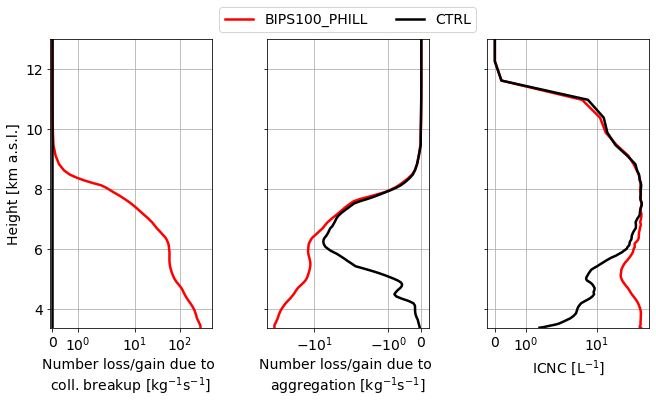

In [11]:
if SIM == '':
    raise SystemExit("Please set the SIM variable.")

fig,axs = plt.subplots(1,3,figsize=(9,5.5),sharey=True,constrained_layout = True)
axs[0].plot(sim_nw.variables['DNI_BR'][:,:,0,0].mean(axis=0),ZZASL_nw_sim/1e3,'r',lw=2.5)
axs[0].plot(ctrl_nw.variables['DNI_BR'][:,:,0,0].mean(axis=0),ZZASL_nw_sim/1e3,'k',lw=2.5)
axs[1].plot(sim_nw.variables['DNI_AGG'][:,:,0,0].mean(axis=0)+sim_nw.variables['DNS_AGG'][:,:,0,0].mean(axis=0),ZZASL_nw_sim/1e3,'r', lw=2.5,label=SIM)
axs[1].plot(ctrl_nw.variables['DNI_AGG'][:,:,0,0].mean(axis=0)+ctrl_nw.variables['DNS_AGG'][:,:,0,0].mean(axis=0),ZZASL_nw_sim/1e3,'k',lw=2.5, label='CTRL')
axs[2].plot(ICNC_NW_profile_sim.mean(axis=0), ZZASL_nw_sim/1e3, 'r', lw=2.5)
axs[2].plot(ICNC_NW_profile.mean(axis=0), ZZASL_nw/1e3, 'k', lw=2.5)
axs[0].set_ylim(3.368,13)
axs[0].set_ylabel('Height [km a.s.l.]')
axs[0].set_xlabel('Number loss/gain due to \ncoll. breakup [kg$^{-1}$s$^{-1}$]')
axs[1].set_xlabel('Number loss/gain due to \naggregation [kg$^{-1}$s$^{-1}$]')
axs[0].set_xscale('symlog')
axs[0].set_xlim(-0.1,5e2)
axs[1].set_xscale('symlog')
axs[2].set_xscale('symlog')
axs[2].set_xlabel('ICNC [L$^{-1}$]')
for ax in axs.flatten():
    ax.grid()
_=axs[1].legend(ncol=2,bbox_to_anchor = (0.5,1), loc='lower center')

> **Question 12** Describe the different profiles and explain the cofluctuations between the different variables, for the two runs of simulations:\
 a) Look at the left plot (breakup tendencies) and right plot (ICNC). What do you observe for the CNTRL run and for the chosen simulation? Is this consistent?\

*In the left plot, we see that collisional breakup is activated around 9km, at first not very strongly; it becomes more relevant around ~7km asl. In the right plot, we see that the ICNC in the BIPS100_PHILL simulation starts to be significantly larger than the CNTRL one around 6-7 km asl, as a result of the increased production of ICNC through BR. It is normal that there is a slight gap in the altitude where the ICNC increase becomes visible compared to the increase in coll.br. because at first the number of ice crystals produced through BR is small compared to the existing ICNC.*
 
 b) Look at the central plot (aggregation tendencies). What do you observe for the two runs? Propose an explanation.\
*For both runs, the aggregation begins around 9km (aggregation of ice crystals results in a decrease of ICNC, hence the negative values). For the CNTRL run, aggregation becomes less important below 6km asl, while it continues to increase for the BIPS100_PHILL run. We can hypotesize that this is due to the reduced availability of ice crystals in this altitude range in the CNTRL run (fewer ice crystals means aggregation is less likely). Note that in the BIPS100_PHILL simulation, more aggregation takes place and in spite of this, the ICNC remains higher: the production of ice crystals through collisional breakup produces more crystals than the consumption of crystals through aggregation (confirmed if we compare the values in the left and central plots).*
 
 c) Compare the left and central panels: do you observe any cofluctuations? Propose an explanation.
*In the BIPS100_PHILL run, the tendencies of collisional breakup and aggregation seem almost perfectly anti-correlated, meaning that the processes take place at the same time. This can be explained by the fact that both are collisional processes, i.e., they require the collision between particles (either for the generation of new fragments, or for the clumping together of crystals).*